# Texture
I've never worked with images before, so I started this textures notebook to make tests with known techniques to find textures in an image. This is the first thing I'm coding in the project because I think that the texture information of the images will be the base for every thing else, with the textures of the image found I will be able to look into diferent regions in the image and say if they are correlated or not.
### Links
[Here](https://courses.cs.washington.edu/courses/cse576/book/ch7.pdf) you can find the document I'm using as reference.

[Here](https://en.wikipedia.org/wiki/Image_texture), [here](https://en.wikipedia.org/wiki/Texel_(graphics)) and [here](https://en.wikipedia.org/wiki/Voronoi_diagram) are Wikipedia pages with a few definitions that I'm also trying to understand in order to make progress within the project.

In [1]:
import numpy as np
import imageio as imgio
import matplotlib.pyplot as plt

## Texture descriptors
### Laws texture energy maps
I've found the Laws texture energy maps an interesting metric, it gives me a 9 dimensional vector for each pixel in the image.

In [25]:
# so here I create the vectors that are used to create the matrices to be used in the cross correlation
# to get the 9 dimensions of Laws texture energy
L5 = np.array([ 1,  4,  6,  4,  1, ], dtype=float) # level
E5 = np.array([ -1,  -2,  0,  2,  1 ], dtype=float) # edge
S5 = np.array([ -1,   0,  2,   0,  -1 ], dtype=float) # spot
R5 = np.array([ 1,  -4,  6,  -4,  1 ], dtype=float) # ripple

In [28]:
# the function to get the outer product of two vectors
def outerProduct(v1, v2):
    mat = np.zeros((v1.shape[0], v2.shape[0]))
    for i in range(v1.shape[0]):
        mat[i] = np.multiply(v2, v1[i])
    return mat

# function that paddifies a matrix by 'pad' number of zeros in both axis
def zeroPaddify(im, pad):
    newim = np.zeros((im.shape[0] + 2 * pad, im.shape[1] + 2 * pad), dtype=im.dtype)
    newim[pad : pad + im.shape[0], pad : pad + im.shape[1]] = im
    return newim

# the function used to remove ilumination effects in the given image, used as preprocessing of
# the image in the Laws texture energy
def removeLuminosityEffect(im):
    pimg = zeroPaddify(im, 7)
    rangej = range(7, im.shape[1] + 7)
    fimg = im.copy()
    for i in range(7, im.shape[0] + 7):
        for j in rangej:
            li_i = i - 7
            li_j = j - 7
            mean = np.mean(pimg[li_i:i+7, li_j:j+7])
            fimg[li_i][li_j] -= mean
    return fimg

# function to normalize a matrix between rmin and rmax values
def normalize(im, rmin = 0, rmax = 255):
    if len(im.shape) == 2:
        # gets the max and min values in the image
        vmax = im.max()
        vmin = im.min()
        # makes its values be between rmin and rmax
        if vmin != vmax:
            im_n = np.multiply((im - vmin), (rmax - rmin) / (vmax - vmin)) + rmin
        elif vmax != 0:
            im_n = im * (rmax - rmin) / vmax + rmin

    else:
        im_n = im.copy().astype(np.float)
        for i in range(im.shape[2]):
            im_channel = im[:,:,i].astype(np.float)
            # gets the max and min values in the image
            vmax = np.max(im_channel)
            vmin = np.min(im_channel)
            # makes its values be between rmin and rmax
            if vmin != vmax:
                im_n[:,:,i] = np.multiply((im_channel - vmin), (rmax - rmin) / (vmax - vmin)) + rmin
            elif vmax != 0:
                im_n[:,:,i] = im_channel * (rmax - rmin) / vmax + rmin

    if(rmin >= 0 and rmax <= 255):
        return im_n.astype(np.uint8)

    return im_n

# limiarization - thresholds an image
def limiarize(im, T):
    last_T = 1000

    # finds the optimal T
    while abs(last_T - T) >= 0.5:
        # gets the values of the pixels that are in group 1
        G1 = im[np.where(im > T)]
        # gets how many values are in group 1
        nG1 = len(G1)

        # gets the values of the pixels that are in group 2
        G2 = im[np.where(im <= T)]
        # gets how many values are in group 2
        nG2 = len(G2)

        # computes the means of the groups
        mG1 = np.sum(G1) / float(nG1)
        mG2 = np.sum(G2) / float(nG2)

        # updates T and last_T
        last_T = T
        T = (mG1 + mG2) * 0.5

    # binarises the image
    fimg = np.where(im > T, 1, 0)

    # normalizes the limiarized image
    fimg = normalize(fimg)

    return fimg.astype(np.uint8)

# function that constructs a symmetric matrix to get a
# padded matrix symetric in its limits
# for example a matrix of weights 5x5 processing a matrix
# also 5x5 would need a padded matrix like the following
# to process all pixels correctly
#                                         A       |       B        |      C
#                                           7  2  | 6  7  8  9  10 | 4  9
#                                           6  1  | 1  2  3  4  5  | 5  10
#                                        ------------------------------------
#              1  2  3  4  5                2  1  | 1  2  3  4  5  | 5  4
#              6  7  8  9  10               7  6  | 6  7  8  9  10 | 10 9
# original --> 11 12 13 14 15  padded --> H 12 11 | 11 12 13 14 15 | 15 14 D
#  image       16 17 18 19 20    one        17 16 | 16 17 18 19 20 | 20 19
#              21 22 23 24 25               22 21 | 21 22 23 24 25 | 25 24
#                                        ------------------------------------
#                                           16 21 | 21 22 23 24 25 | 25 20
#                                           17 22 | 16 17 18 19 20 | 24 19
#                                         G       |       F        |       E
def symPaddify(im, pad):
    newim = np.zeros((im.shape[0] + 2 * pad, im.shape[1] + 2 * pad))

    # creates the center of the padded image
    newim[pad : pad + im.shape[0], pad : pad + im.shape[1]] = im

    # creates the A region of the padded image
    newim[0:pad, 0:pad] = im[pad-1::-1, pad-1::-1]

    # creates the B region of the padded image
    newim[0:pad, pad:newim.shape[1]-pad] = im[pad-1::-1, :]

    # creates the C region of the padded image
    newim[0:pad, -pad:] = im[pad-1::-1, -1:-pad-1:-1]

    # creates the D region of the padded image
    newim[pad:newim.shape[0]-pad, -pad:] = im[:, -1:-pad-1:-1]

    # creates the E region of the padded image
    newim[-pad:, -pad:] = im[-1:-pad-1:-1, -1:-pad-1:-1]

    # creates the F region of the padded image
    newim[-pad:, pad:newim.shape[1]-pad] = im[-1:-pad-1:-1, :]

    # creates the G region of the padded image
    newim[-pad:, 0:pad] = im[-1:-pad-1:-1, pad-1::-1]

    # creates the H region of the padded image
    newim[pad:newim.shape[0]-pad, 0:pad] = im[:, pad-1::-1]

    return newim

def filtering2D(im, weights):
    n = len(weights[0])
    wcenter = n // 2 # the center of the weights matrix, assumes that it is a square matrix

    sym = symPaddify(im, wcenter)

    # filters the image
    fimg = np.zeros(im.shape)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            # gets a submatrix of the image centered at [i, j]
            submat = sym[i : n + i : 1, j : n + j : 1]
            # gets the sum of the dot product of the rows of the submatrix and the rows of the weights matrix
            for k in range(n):
                fimg[i][j] += np.abs(np.dot(submat[k], weights[k]))

    return fimg

# the function to compute the 9 Laws texture energy maps
def getLawsEnergyMaps(im):
    # here are defined the 16 matrices used on the cross correlation
    # to get the 16 maps
    L5E5 = [[ -1.0,  -2.0,   0.0,   2.0,   1.0],
            [ -4.0,  -8.0,   0.0,   8.0,   4.0],
            [ -6.0, -12.0,   0.0,  12.0,   6.0],
            [ -4.0,  -8.0,   0.0,   8.0,   4.0],
            [ -1.0,  -2.0,   0.0,   2.0,   1.0]]
    E5L5 = [[ -1.0,  -4.0,  -6.0,  -4.0,  -1.0],
            [ -2.0,  -8.0, -12.0,  -8.0,  -2.0],
            [  0.0,   0.0,   0.0,   0.0,   0.0],
            [  2.0,   8.0,  12.0,   8.0,   2.0],
            [  1.0,   4.0,   6.0,   4.0,   1.0]]
    L5R5 = [[  1.0,  -4.0,   6.0,  -4.0,   1.0],
            [  4.0, -16.0,  24.0, -16.0,   4.0],
            [  6.0, -24.0,  36.0, -24.0,   6.0],
            [  4.0, -16.0,  24.0, -16.0,   4.0],
            [  1.0,  -4.0,   6.0,  -4.0,   1.0]]
    R5L5 = [[  1.0,   4.0,   6.0,   4.0,   1.0],
            [ -4.0, -16.0, -24.0, -16.0,  -4.0],
            [  6.0,  24.0,  36.0,  24.0,   6.0],
            [ -4.0, -16.0, -24.0, -16.0,  -4.0],
            [  1.0,   4.0,   6.0,   4.0,   1.0]]
    E5S5 = [[ 1.0, -0.0, -2.0, -0.0,  1.0],
            [ 2.0, -0.0, -4.0, -0.0,  2.0],
            [-0.0,  0.0,  0.0,  0.0, -0.0],
            [-2.0,  0.0,  4.0,  0.0, -2.0],
            [-1.0,  0.0,  2.0,  0.0, -1.0]]
    S5E5 = [[ 1.0,  2.0, -0.0, -2.0, -1.0],
            [-0.0, -0.0,  0.0,  0.0,  0.0],
            [-2.0, -4.0,  0.0,  4.0,  2.0],
            [-0.0, -0.0,  0.0,  0.0,  0.0],
            [ 1.0,  2.0, -0.0, -2.0, -1.0]]
    S5S5 = [[ 1.0, -0.0, -2.0, -0.0,  1.0],
            [-0.0,  0.0,  0.0,  0.0, -0.0],
            [-2.0,  0.0,  4.0,  0.0, -2.0],
            [-0.0,  0.0,  0.0,  0.0, -0.0],
            [ 1.0, -0.0, -2.0, -0.0,  1.0]]
    R5R5 = [[  1.0,  -4.0,   6.0,  -4.0,   1.0],
            [ -4.0,  16.0, -24.0,  16.0,  -4.0],
            [  6.0, -24.0,  36.0, -24.0,   6.0],
            [ -4.0,  16.0, -24.0,  16.0,  -4.0],
            [  1.0,  -4.0,   6.0,  -4.0,   1.0]]
    L5S5 = [[-1.0,  0.0,  2.0,  0.0, -1.0],
            [-4.0,  0.0,  8.0,  0.0, -4.0],
            [-6.0,  0.0, 12.0,  0.0, -6.0],
            [-4.0,  0.0,  8.0,  0.0, -4.0],
            [-1.0,  0.0,  2.0,  0.0, -1.0]]
    S5L5 = [[-1.0, -4.0, -6.0, -4.0, -1.0],
            [ 0.0,  0.0,  0.0,  0.0,  0.0],
            [ 2.0,  8.0, 12.0,  8.0,  2.0],
            [ 0.0,  0.0,  0.0,  0.0,  0.0],
            [-1.0, -4.0, -6.0, -4.0, -1.0]]
    E5E5 = [[ 1.0,  2.0, -0.0, -2.0, -1.0],
            [ 2.0,  4.0, -0.0, -4.0, -2.0],
            [-0.0, -0.0,  0.0,  0.0,  0.0],
            [-2.0, -4.0,  0.0,  4.0,  2.0],
            [-1.0, -2.0,  0.0,  2.0,  1.0]]
    E5R5 = [[ -1.0,   4.0,  -6.0,   4.0,  -1.0],
            [ -2.0,   8.0, -12.0,   8.0,  -2.0],
            [  0.0,  -0.0,   0.0,  -0.0,   0.0],
            [  2.0,  -8.0,  12.0,  -8.0,   2.0],
            [  1.0,  -4.0,   6.0,  -4.0,   1.0]]
    R5E5 = [[ -1.0,  -2.0,   0.0,   2.0,   1.0],
            [  4.0,   8.0,  -0.0,  -8.0,  -4.0],
            [ -6.0, -12.0,   0.0,  12.0,   6.0],
            [  4.0,   8.0,  -0.0,  -8.0,  -4.0],
            [ -1.0,  -2.0,   0.0,   2.0,   1.0]]
    S5R5 = [[-1.0,  4.0, -6.0,  4.0, -1.0],
            [ 0.0, -0.0,  0.0, -0.0,  0.0],
            [ 2.0, -8.0, 12.0, -8.0,  2.0],
            [ 0.0, -0.0,  0.0, -0.0,  0.0],
            [-1.0,  4.0, -6.0,  4.0, -1.0]]
    R5S5 = [[-1.0,  0.0,  2.0,  0.0, -1.0],
            [ 4.0, -0.0, -8.0, -0.0,  4.0],
            [-6.0,  0.0, 12.0,  0.0, -6.0],
            [ 4.0, -0.0, -8.0, -0.0,  4.0],
            [-1.0,  0.0,  2.0,  0.0, -1.0]]
    # removes the luminosity effects of the image
    im_sem_luz = removeLuminosityEffect(im)
    # computes the 16 energy maps
    im_L5E5 = filtering2D(moon_sem_luz, L5E5).astype(float)
    im_E5L5 = filtering2D(moon_sem_luz, E5L5).astype(float)
    im_L5R5 = filtering2D(moon_sem_luz, L5R5).astype(float)
    im_R5L5 = filtering2D(moon_sem_luz, R5L5).astype(float)
    im_E5S5 = filtering2D(moon_sem_luz, E5S5).astype(float)
    im_S5E5 = filtering2D(moon_sem_luz, S5E5).astype(float)
    im_S5S5 = filtering2D(moon_sem_luz, S5S5).astype(float)
    im_R5R5 = filtering2D(moon_sem_luz, R5R5).astype(float)
    im_L5S5 = filtering2D(moon_sem_luz, L5S5).astype(float)
    im_S5L5 = filtering2D(moon_sem_luz, S5L5).astype(float)
    im_E5E5 = filtering2D(moon_sem_luz, E5E5).astype(float)
    im_E5R5 = filtering2D(moon_sem_luz, E5R5).astype(float)
    im_R5E5 = filtering2D(moon_sem_luz, R5E5).astype(float)
    im_S5R5 = filtering2D(moon_sem_luz, S5R5).astype(float)
    im_R5S5 = filtering2D(moon_sem_luz, R5S5).astype(float)
    # summarizes then in 9 maps by averaging the symetric ones
    im_fs = []
    im_fs.append(((im_L5E5 + im_E5L5) / 2.0))
    im_fs.append(((im_L5R5 + im_R5L5) / 2.0))
    im_fs.append(((im_E5S5 + im_S5E5) / 2.0))
    im_fs.append(im_S5S5)
    im_fs.append(im_R5R5)
    im_fs.append(((im_L5S5 + im_S5L5) / 2.0))
    im_fs.append(im_E5E5)
    im_fs.append(((im_E5R5 + im_R5E5) / 2.0))
    im_fs.append(((im_S5R5 + im_R5S5) / 2.0))
    return im_fs

# function to binarize an image, uses a neighbourhood of 8 to generate the
# binary value for the pixel we want to compute
def binarize(im):
    fimg = np.zeros((im.shape[0] + 2, im.shape[1] + 2)).astype(np.uint8)
    fimg[1 : 1 + im.shape[0], 1 : 1 + im.shape[1]] = im
    b8 = np.greater(fimg[:fimg.shape[0] - 2, :fimg.shape[1] - 2], im).astype(np.uint8)
    b7 = np.left_shift(np.greater(fimg[:fimg.shape[0] - 2, 1:fimg.shape[1] - 1], im), 1)
    b6 = np.left_shift(np.greater(fimg[:fimg.shape[0] - 2, 2:], im), 2)
    b5 = np.left_shift(np.greater(fimg[1:fimg.shape[0] - 1, 2:], im), 3)
    b4 = np.left_shift(np.greater(fimg[2:, 2:], im), 4)
    b3 = np.left_shift(np.greater(fimg[2:, 1:fimg.shape[1] - 1], im), 5)
    b2 = np.left_shift(np.greater(fimg[2:, :fimg.shape[1] - 2], im), 6)
    b1 = np.left_shift(np.greater(fimg[1:fimg.shape[0] - 1, :fimg.shape[1] - 2], im), 7)
    # shows the images that each bit represents
    plt.figure(dpi=200)
    plt.subplot(421)
    plt.imshow(b1, cmap = 'gray'); plt.axis('off')
    plt.subplot(422)
    plt.imshow(b2, cmap = 'gray'); plt.axis('off')
    plt.subplot(423)
    plt.imshow(b3, cmap = 'gray'); plt.axis('off')
    plt.subplot(424)
    plt.imshow(b4, cmap = 'gray'); plt.axis('off')
    plt.subplot(425)
    plt.imshow(b5, cmap = 'gray'); plt.axis('off')
    plt.subplot(426)
    plt.imshow(b6, cmap = 'gray'); plt.axis('off')
    plt.subplot(427)
    plt.imshow(b7, cmap = 'gray'); plt.axis('off')
    plt.subplot(428)
    plt.imshow(b8, cmap = 'gray'); plt.axis('off')
    plt.show()
    rimg = np.sum([b1, b2, b3, b4, b5, b6, b7, b8], axis = 0).astype(np.uint8)
    return rimg

While reading the technique of the Law Texture energy maps I realised that most of the cross correlations made were then summed and averaged with its symetric one, then I decided to test an aproach that would skip the steps of computing the 16 energy maps and then averaging most of then (let's call it 'skipper'), so I can compute the 9 maps faster. In order to do so, I just average the cross correlation matrices.

In [4]:
# get the cross correlation matrices that will compute directly the final maps in the skipper method
L5E5andE5L5 = np.multiply(outerProduct(L5, E5), 0.5) + np.multiply(outerProduct(E5, L5), 0.5)
L5R5andR5L5 = np.multiply(outerProduct(L5, R5), 0.5) + np.multiply(outerProduct(R5, L5), 0.5)
E5S5andS5E5 = np.multiply(outerProduct(E5, S5), 0.5) + np.multiply(outerProduct(S5, E5), 0.5)
S5S5 = outerProduct(S5, S5)
R5R5 = outerProduct(R5, R5)
L5S5andS5L5 = np.multiply(outerProduct(L5, S5), 0.5) + np.multiply(outerProduct(S5, L5), 0.5)
E5E5 = outerProduct(E5, E5)
E5R5andR5E5 = np.multiply(outerProduct(E5, R5), 0.5) + np.multiply(outerProduct(R5, E5), 0.5)
S5R5andR5S5 = np.multiply(outerProduct(S5, R5), 0.5) + np.multiply(outerProduct(R5, S5), 0.5)

Then I needed an image to test them both, this image is not intended to be used in the project itself.

In [5]:
# load an image to test the texture algorithms
moon = imgio.imread("moon.png")

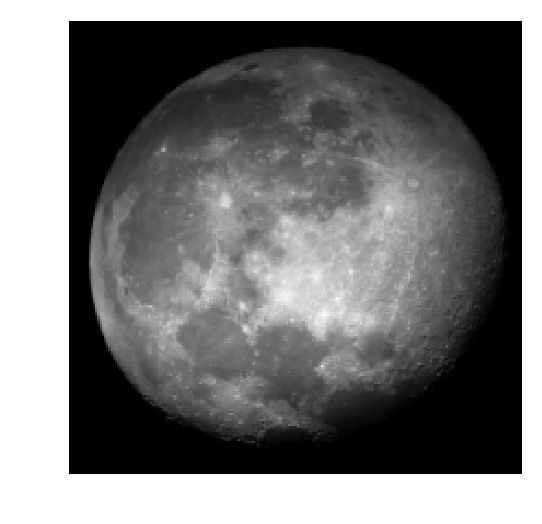

In [6]:
# here is the image I've loaded
plt.figure(dpi=150)
plt.imshow(moon)
plt.axis('off')
plt.show()

Then I compute the Laws energy maps using the skipper method

In [7]:
moon_sem_luz = removeLuminosityEffect(moon[:,:,0])
moon_fs = []
moon_fs.append(filtering2D(moon_sem_luz, L5E5andE5L5))
moon_fs.append(filtering2D(moon_sem_luz, L5R5andR5L5))
moon_fs.append(filtering2D(moon_sem_luz, E5S5andS5E5))
moon_fs.append(filtering2D(moon_sem_luz, S5S5))
moon_fs.append(filtering2D(moon_sem_luz, R5R5))
moon_fs.append(filtering2D(moon_sem_luz, L5S5andS5L5))
moon_fs.append(filtering2D(moon_sem_luz, E5E5))
moon_fs.append(filtering2D(moon_sem_luz, E5R5andR5E5))
moon_fs.append(filtering2D(moon_sem_luz, S5R5andR5S5))

I got curious about the effect of removing the luminosity effects, then this is the preprocessed image that is used to compute the maps.

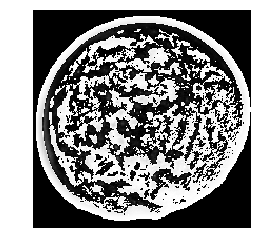

In [8]:
plt.imshow(moon_sem_luz, cmap='gray')
plt.axis('off')
plt.show()

###### TODO later
I think that, maybe, the maps could be computed in a LUV color space using the V channel? I'll try it later.

Then I compute the maps as described by the document linked at the top of the page, computing the 16 maps and then the 9 final ones.

In [9]:
moon_le = getLawsEnergyMaps(moon[:,:,0])

Here is the result of the skipper method:

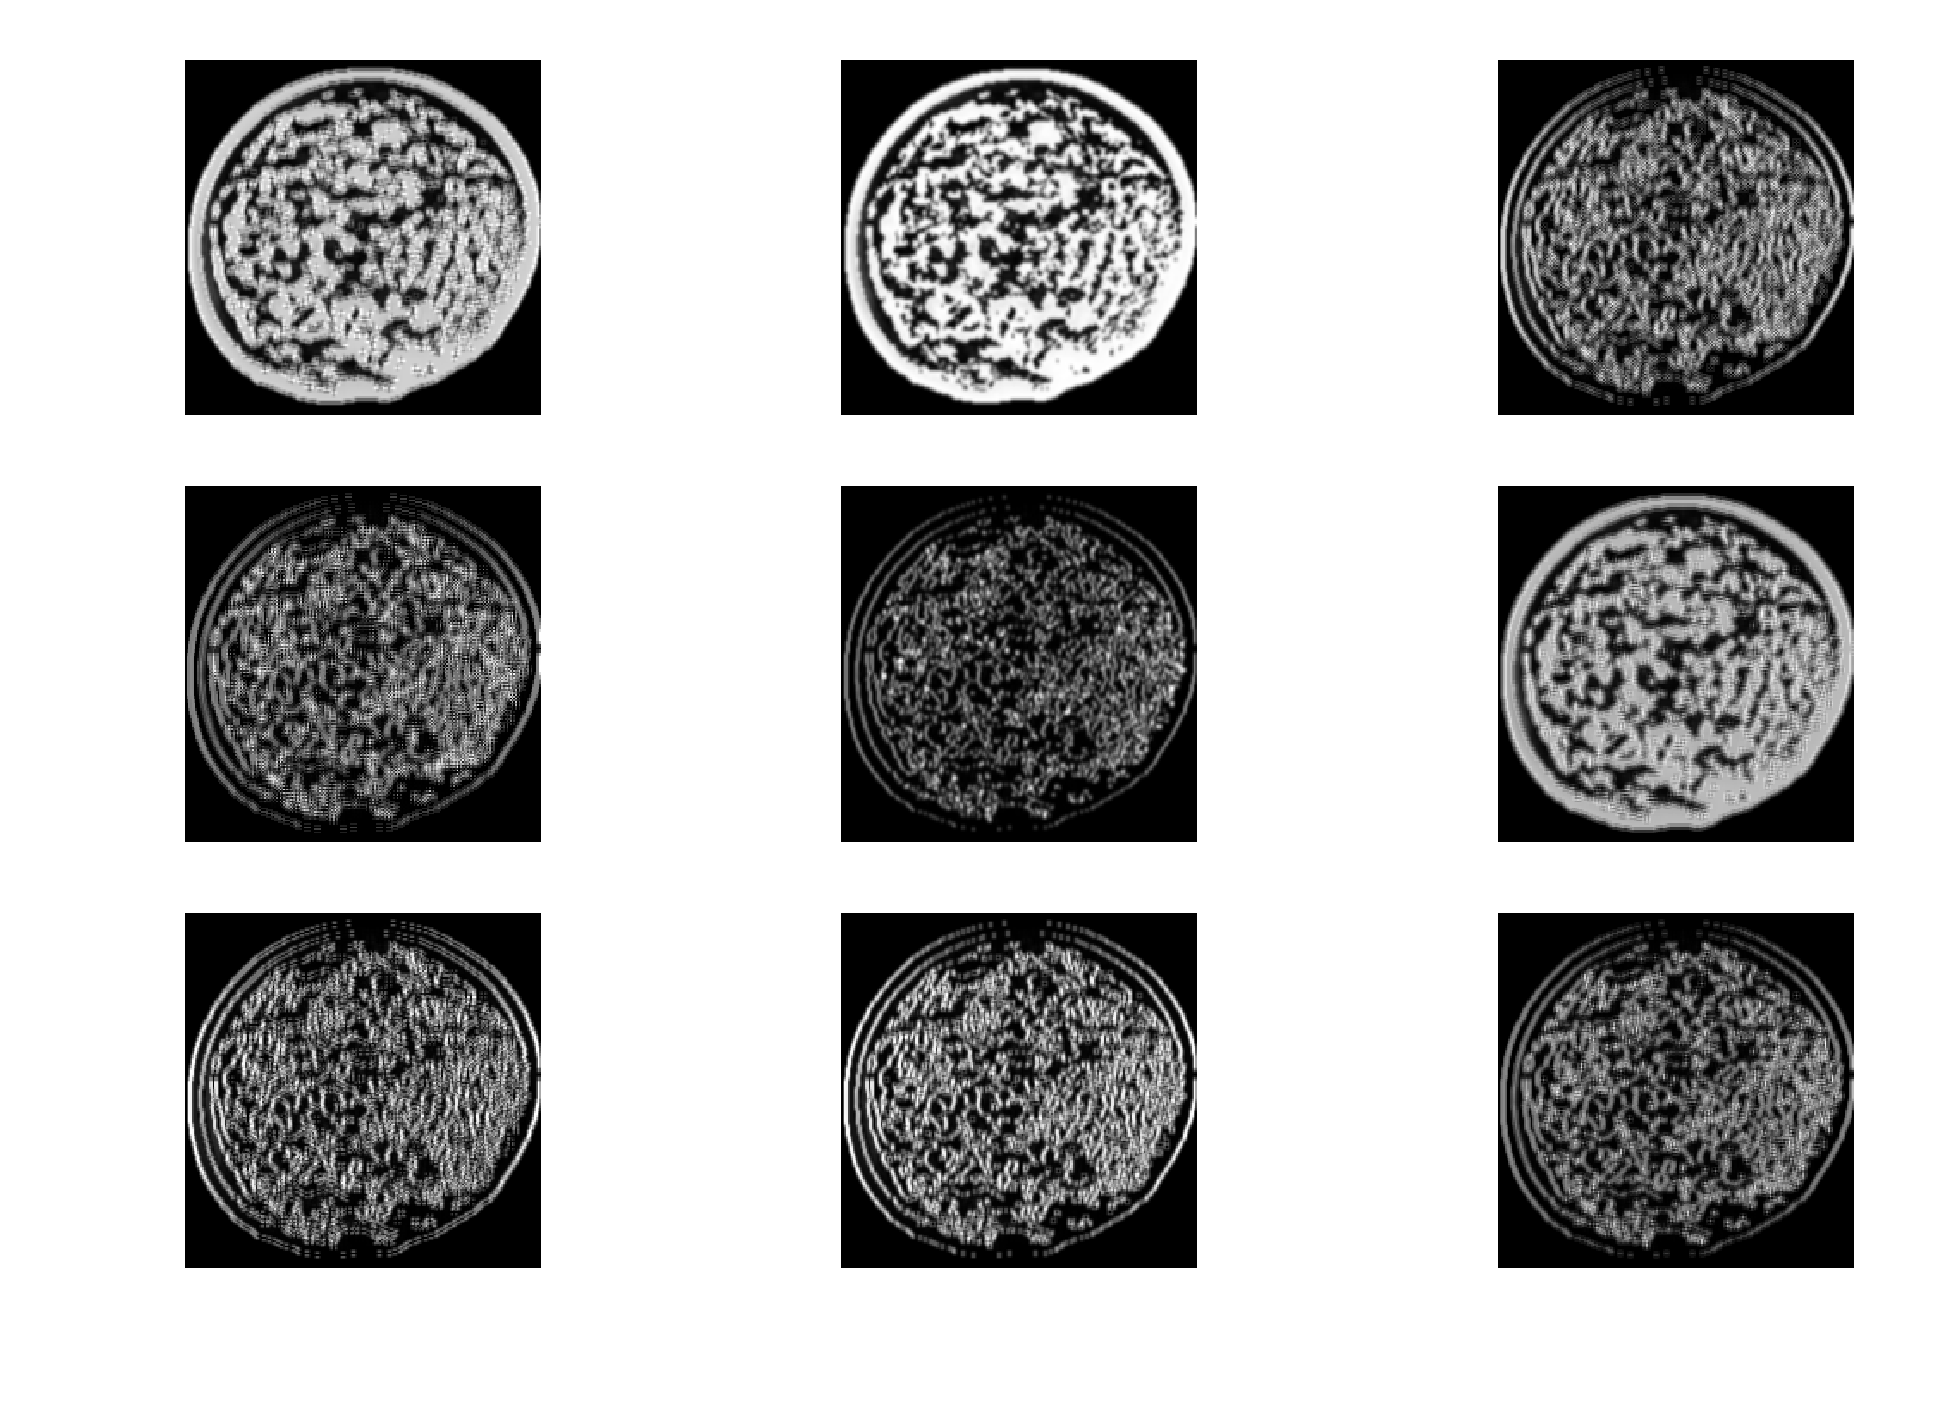

In [10]:
plt.figure(dpi=400)
plt.subplot(331); plt.imshow(moon_le[0], cmap='gray'); plt.axis('off')
plt.subplot(332); plt.imshow(moon_le[1], cmap='gray'); plt.axis('off')
plt.subplot(333); plt.imshow(moon_le[2], cmap='gray'); plt.axis('off')
plt.subplot(334); plt.imshow(moon_le[3], cmap='gray'); plt.axis('off')
plt.subplot(335); plt.imshow(moon_le[4], cmap='gray'); plt.axis('off')
plt.subplot(336); plt.imshow(moon_le[5], cmap='gray'); plt.axis('off')
plt.subplot(337); plt.imshow(moon_le[6], cmap='gray'); plt.axis('off')
plt.subplot(338); plt.imshow(moon_le[7], cmap='gray'); plt.axis('off')
plt.subplot(339); plt.imshow(moon_le[8], cmap='gray'); plt.axis('off')
plt.show()

Here is the result of the regular method:

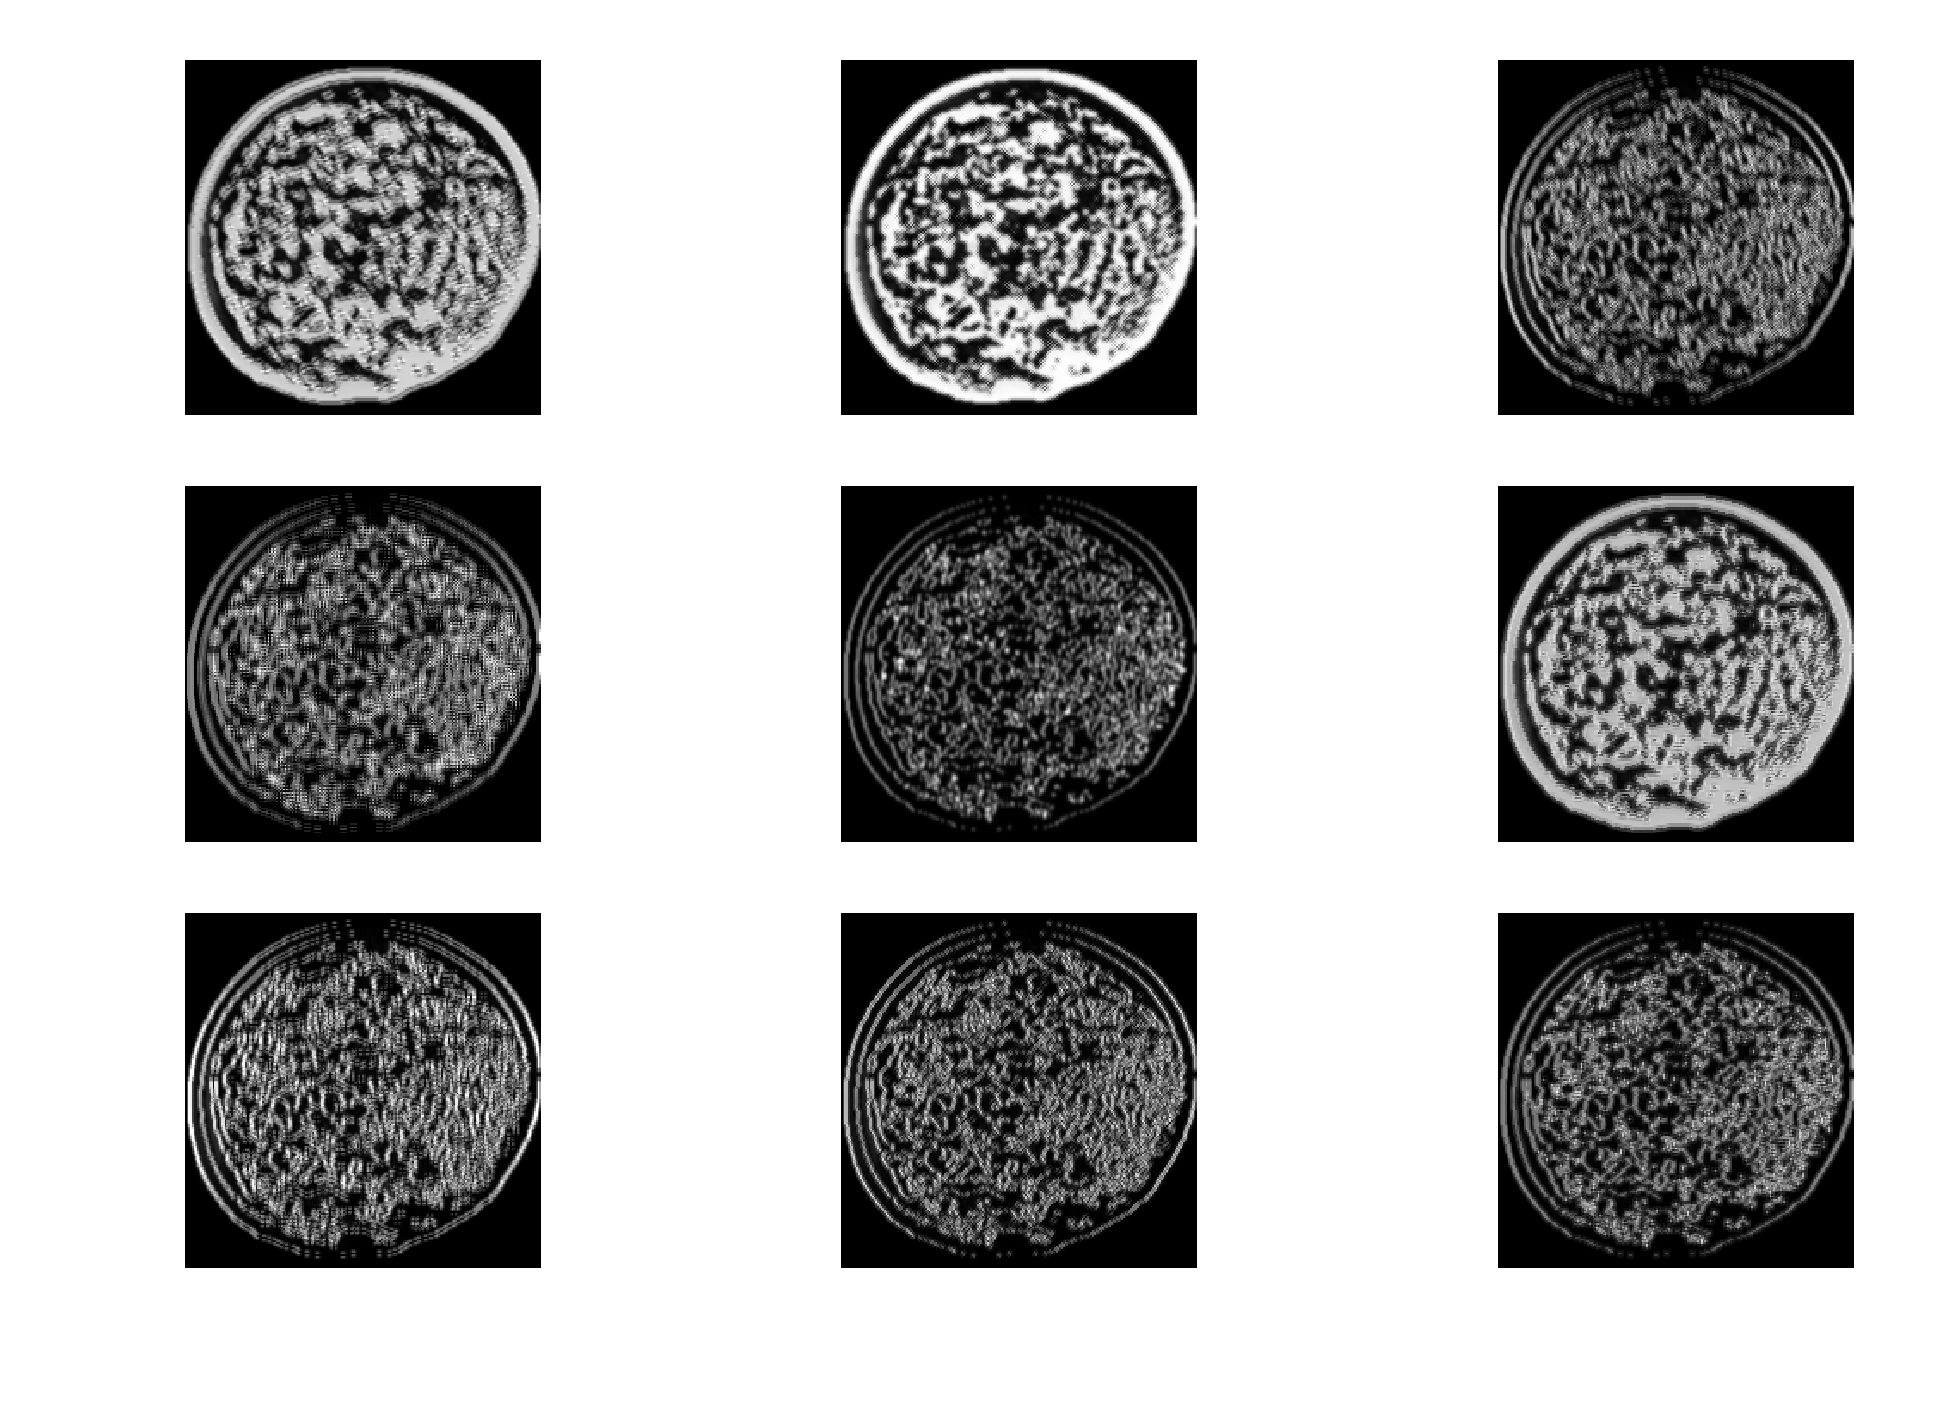

In [11]:
plt.figure(dpi=400)
plt.subplot(331); plt.imshow(moon_fs[0], cmap='gray'); plt.axis('off')
plt.subplot(332); plt.imshow(moon_fs[1], cmap='gray'); plt.axis('off')
plt.subplot(333); plt.imshow(moon_fs[2], cmap='gray'); plt.axis('off')
plt.subplot(334); plt.imshow(moon_fs[3], cmap='gray'); plt.axis('off')
plt.subplot(335); plt.imshow(moon_fs[4], cmap='gray'); plt.axis('off')
plt.subplot(336); plt.imshow(moon_fs[5], cmap='gray'); plt.axis('off')
plt.subplot(337); plt.imshow(moon_fs[6], cmap='gray'); plt.axis('off')
plt.subplot(338); plt.imshow(moon_fs[7], cmap='gray'); plt.axis('off')
plt.subplot(339); plt.imshow(moon_fs[8], cmap='gray'); plt.axis('off')
plt.show()

They look pretty much the same, then let's see if there is any difference:

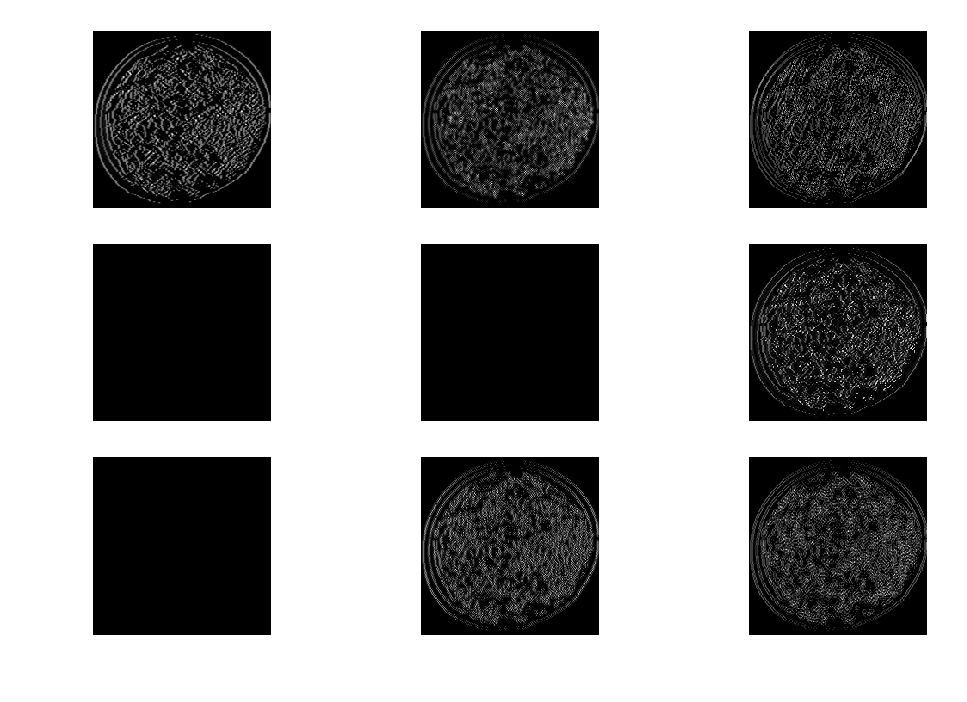

In [24]:
# compute the difference between both methods and show the resultant images
plt.figure(dpi=200)
plt.subplot(331); plt.imshow(moon_le[0].astype(float) - moon_fs[0].astype(float), cmap='gray'); plt.axis('off')
plt.subplot(332); plt.imshow(moon_le[1].astype(float) - moon_fs[1].astype(float), cmap='gray'); plt.axis('off')
plt.subplot(333); plt.imshow(moon_le[2].astype(float) - moon_fs[2].astype(float), cmap='gray'); plt.axis('off')
plt.subplot(334); plt.imshow(moon_le[3].astype(float) - moon_fs[3].astype(float), cmap='gray'); plt.axis('off')
plt.subplot(335); plt.imshow(moon_le[4].astype(float) - moon_fs[4].astype(float), cmap='gray'); plt.axis('off')
plt.subplot(336); plt.imshow(moon_le[5].astype(float) - moon_fs[5].astype(float), cmap='gray'); plt.axis('off')
plt.subplot(337); plt.imshow(moon_le[6].astype(float) - moon_fs[6].astype(float), cmap='gray'); plt.axis('off')
plt.subplot(338); plt.imshow(moon_le[7].astype(float) - moon_fs[7].astype(float), cmap='gray'); plt.axis('off')
plt.subplot(339); plt.imshow(moon_le[8].astype(float) - moon_fs[8].astype(float), cmap='gray'); plt.axis('off')
plt.show()

When we subtract one of the other we see that there are a few diferences, so I can't just skip the temporary 16 maps.

### Local binary patterns (LBP)
The LBP is really often used in texture descriptors, here I compute it and show the contents in each bit of the final image, you can notice how it extracts in each bit the texture information in different directions.

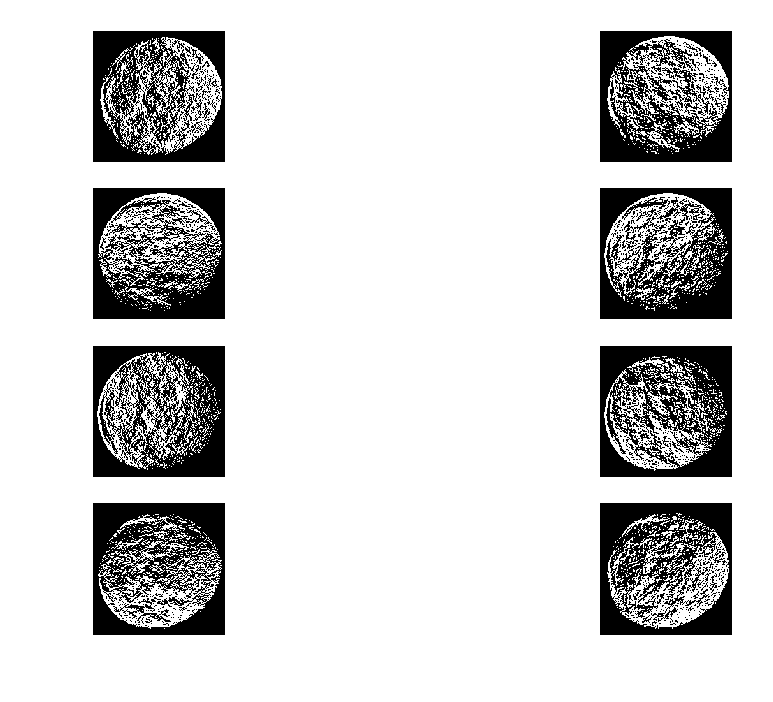

In [29]:
moon_b = binarize(moon[:,:,0])

Here is the resultant image of the LBP:

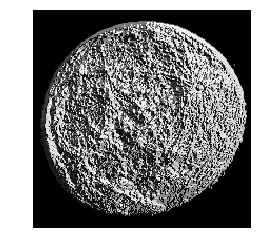

In [30]:
plt.imshow(moon_b, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

## Image segmentation
I was thinking that I would have to segment the image to make the search for the best match of textures around the area where I should do the inpainting, but after asking a few questions to Professor Moacir, I understood that it is not necessary. But as I already was trying to understand the segmentation using the texture, here is what I tested and not entirely understood how works, yet.

First I've read that the segmentation can be done by Voronoi tesselation starting from centroids of texture. I don't really quite understood how to get these centroids, but it started with threasholding the image, then that is what I've done with the 9 Law energy maps that I had (don't know if that is the right thing to use).

In [31]:
# threashold the 9 maps of energy
moon_fs_t = [limiarize(moon_fs[0], 122),
            limiarize(moon_fs[1], 122),
            limiarize(moon_fs[2], 122),
            limiarize(moon_fs[3], 122),
            limiarize(moon_fs[4], 122),
            limiarize(moon_fs[5], 122),
            limiarize(moon_fs[6], 122),
            limiarize(moon_fs[7], 122),
            limiarize(moon_fs[8], 122)]

Here's the result:

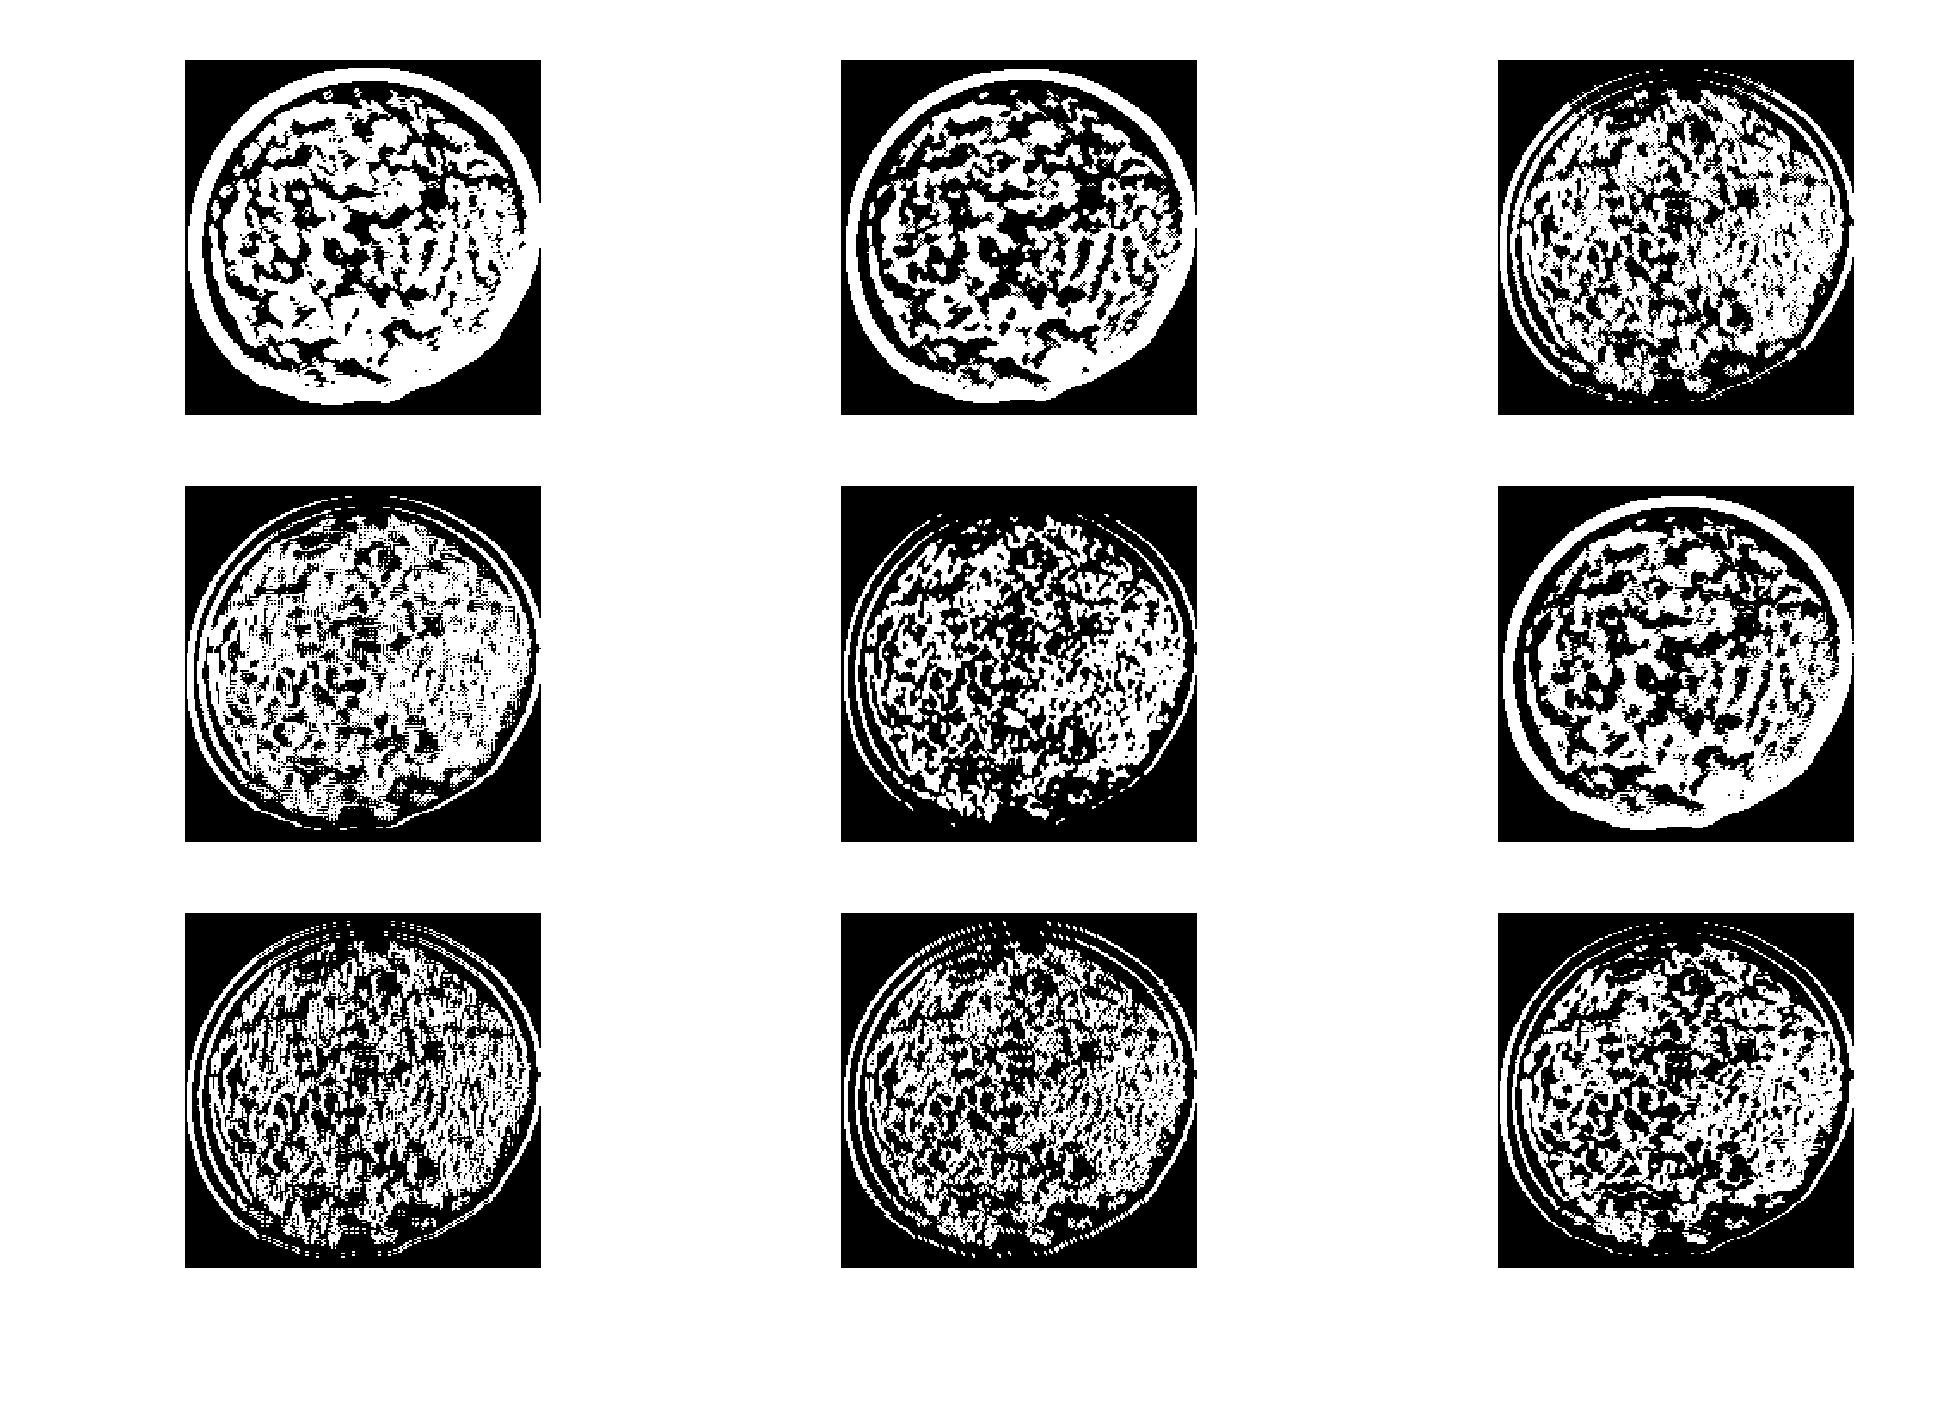

In [17]:
plt.figure(dpi=400)
plt.subplot(331); plt.imshow(moon_fs_t[0], cmap='gray', vmin=0, vmax=255); plt.axis('off')
plt.subplot(332); plt.imshow(moon_fs_t[1], cmap='gray', vmin=0, vmax=255); plt.axis('off')
plt.subplot(333); plt.imshow(moon_fs_t[2], cmap='gray', vmin=0, vmax=255); plt.axis('off')
plt.subplot(334); plt.imshow(moon_fs_t[3], cmap='gray', vmin=0, vmax=255); plt.axis('off')
plt.subplot(335); plt.imshow(moon_fs_t[4], cmap='gray', vmin=0, vmax=255); plt.axis('off')
plt.subplot(336); plt.imshow(moon_fs_t[5], cmap='gray', vmin=0, vmax=255); plt.axis('off')
plt.subplot(337); plt.imshow(moon_fs_t[6], cmap='gray', vmin=0, vmax=255); plt.axis('off')
plt.subplot(338); plt.imshow(moon_fs_t[7], cmap='gray', vmin=0, vmax=255); plt.axis('off')
plt.subplot(339); plt.imshow(moon_fs_t[8], cmap='gray', vmin=0, vmax=255); plt.axis('off')
plt.show()

Well... it's not what I expected, I'm not sure how to extract centroids of them, so I thought "What if I threshold the original image, instead?" and so I did it.

In [18]:
# threshold the original image
moon_t = limiarize(moon[:,:,0], 122)

This is the result:

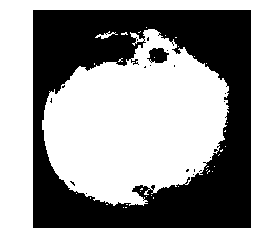

In [19]:
plt.axis('off')
plt.imshow(moon_t, cmap='gray', vmin=0, vmax=255)
plt.show()

Yeah, I definitely can get a centroid from that, but it will be the only centroid in the image, my segmentation will result in the entire image, so how to proceed? Then I decided to threshold the binarized image.

In [20]:
# thresholds the binarized image
moon_b_t = limiarize(moon_b, 122)

Here is the result:

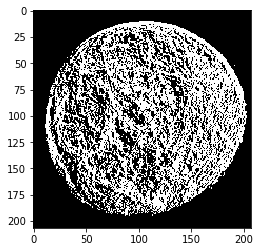

In [21]:
plt.imshow(moon_b_t, cmap='gray', vmin=0, vmax=255)
plt.show()

Again, not sure how to get centroids from that...

And this is the end of segmentation for now, since it will not be used in this project. I kept these tests for the sake of documenting the steps I've taken so far and maybe for future use.